# Covid-19 Analysis

Looking at the Covid-19 data from '2020-03-17' with respect to population. Based on the following analysis, top 5 countries with highest total cases per capita are: 
<br><br>
<b>San Marino</b> (0.003019) <br>
<b>Iceland</b> (0.000563) <br>
<b>Italy</b> (0.000463) <br>
<b>Switzerland</b> (0.000258) <br>
<b>Monaco</b> (0.000233) <br>

Countries with highest death rate per reported cases are: 
<br><br>
<b>Italy</b> (0.0895) <br>
<b>San Marino </b> (0.0882) <br>
<b>Iraq</b> (0.0726) <br>
<b>Algeria</b> (0.0667) <br>
<b>Philippines</b> (0.0642) <br>

## Extracting coronavirus and country data

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [38]:
rdata = pd.read_csv('full_data.csv')
rpopulation_data = pd.read_csv('population_data.csv') 

In [39]:
rdata.head()

,date,location,new_cases,new_deaths,total_cases,total_deaths
0,2020-02-25,Afghanistan,NaN,NaN,1,NaN
1,2020-02-26,Afghanistan,0.0,NaN,1,NaN
2,2020-02-27,Afghanistan,0.0,NaN,1,NaN
3,2020-02-28,Afghanistan,0.0,NaN,1,NaN
4,2020-02-29,Afghanistan,0.0,NaN,1,NaN


In [40]:
rpopulation_data.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101669.0,102046.0,102560.0,103159.0,103774.0,104341.0,104872.0,105366.0,105845.0,NaN
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996973.0,9169410.0,9351441.0,9543205.0,9744781.0,9956320.0,...,29185507.0,30117413.0,31161376.0,32269589.0,33370794.0,34413603.0,35383128.0,36296400.0,37172386.0,NaN
2,Angola,AGO,"Population, total",SP.POP.TOTL,5454933.0,5531472.0,5608539.0,5679458.0,5735044.0,5770570.0,...,23356246.0,24220661.0,25107931.0,26015780.0,26941779.0,27884381.0,28842484.0,29816748.0,30809762.0,NaN
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0,NaN
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,84449.0,83747.0,82427.0,80774.0,79213.0,78011.0,77297.0,77001.0,77006.0,NaN


## Filtering and cleaning data 

In [41]:
print("Data Types", rdata.dtypes)
print("Columns with NaN", rdata.columns[rdata.isna().any()])

Data Types date             object
location         object
new_cases       float64
new_deaths      float64
total_cases       int64
total_deaths    float64
dtype: object
Columns with NaN Index(['new_cases', 'new_deaths', 'total_deaths'], dtype='object')


In [42]:
rdata = rdata.fillna(value = 0)
data = rdata.astype({'new_cases':'int64', 
                     'new_deaths':'int64', 
                     'total_deaths':'int64'})
data.dtypes

date            object
location        object
new_cases        int64
new_deaths       int64
total_cases      int64
total_deaths     int64
dtype: object

In [43]:
latest = data['date'].max()
latest

'2020-03-17'

In [44]:
data = data[data['date'] == latest]
data.head()
data = data.drop('date', axis = 1)
world_record = data[data['location'] == 'World']
data = data.set_index('location')

In [45]:
data = data[data.index != 'World']
print(world_record)

     location  new_cases  new_deaths  total_cases  total_deaths
2866    World      11594         819       179112          7426


In [46]:
max_total_cases = data['total_cases'].max()
print("Max value in total cases", max_total_cases)


Max value in total cases 81116


In [47]:
population = rpopulation_data.filter(['Country Name', '2018'])
population[population['Country Name'] == 'Canada']

,Country Name,2018
33,Canada,37058856.0


In [48]:
population = population.rename(columns = {'Country Name':'location'})
population = population.set_index('location')
population.head(n=1)

,2018
location,
Aruba,105845.0


In [49]:
data['total_cases_pc'] = data['total_cases'].div(data.index.map(population['2018']))
data['total_deaths_pc'] = data['total_deaths'].div(data.index.map(population['2018']))
data['deaths_per_total'] = data['total_deaths'].div(data['total_cases'])
data['deaths_per_total'] = data['deaths_per_total'].round(decimals = 4)
data.head()

,new_cases,new_deaths,total_cases,total_deaths,total_cases_pc,total_deaths_pc,deaths_per_total
location,,,,,,,
Afghanistan,5,0,21,0,5.649355e-07,0.000000e+00,0.0000
Albania,9,0,51,1,1.779250e-05,3.488726e-07,0.0196
Algeria,11,1,60,4,1.420844e-06,9.472292e-08,0.0667
Andorra,12,0,14,0,1.818040e-04,0.000000e+00,0.0000
Antigua and Barbuda,0,0,1,0,1.038573e-05,0.000000e+00,0.0000


In [50]:
data.dtypes

new_cases             int64
new_deaths            int64
total_cases           int64
total_deaths          int64
total_cases_pc      float64
total_deaths_pc     float64
deaths_per_total    float64
dtype: object

## Plots

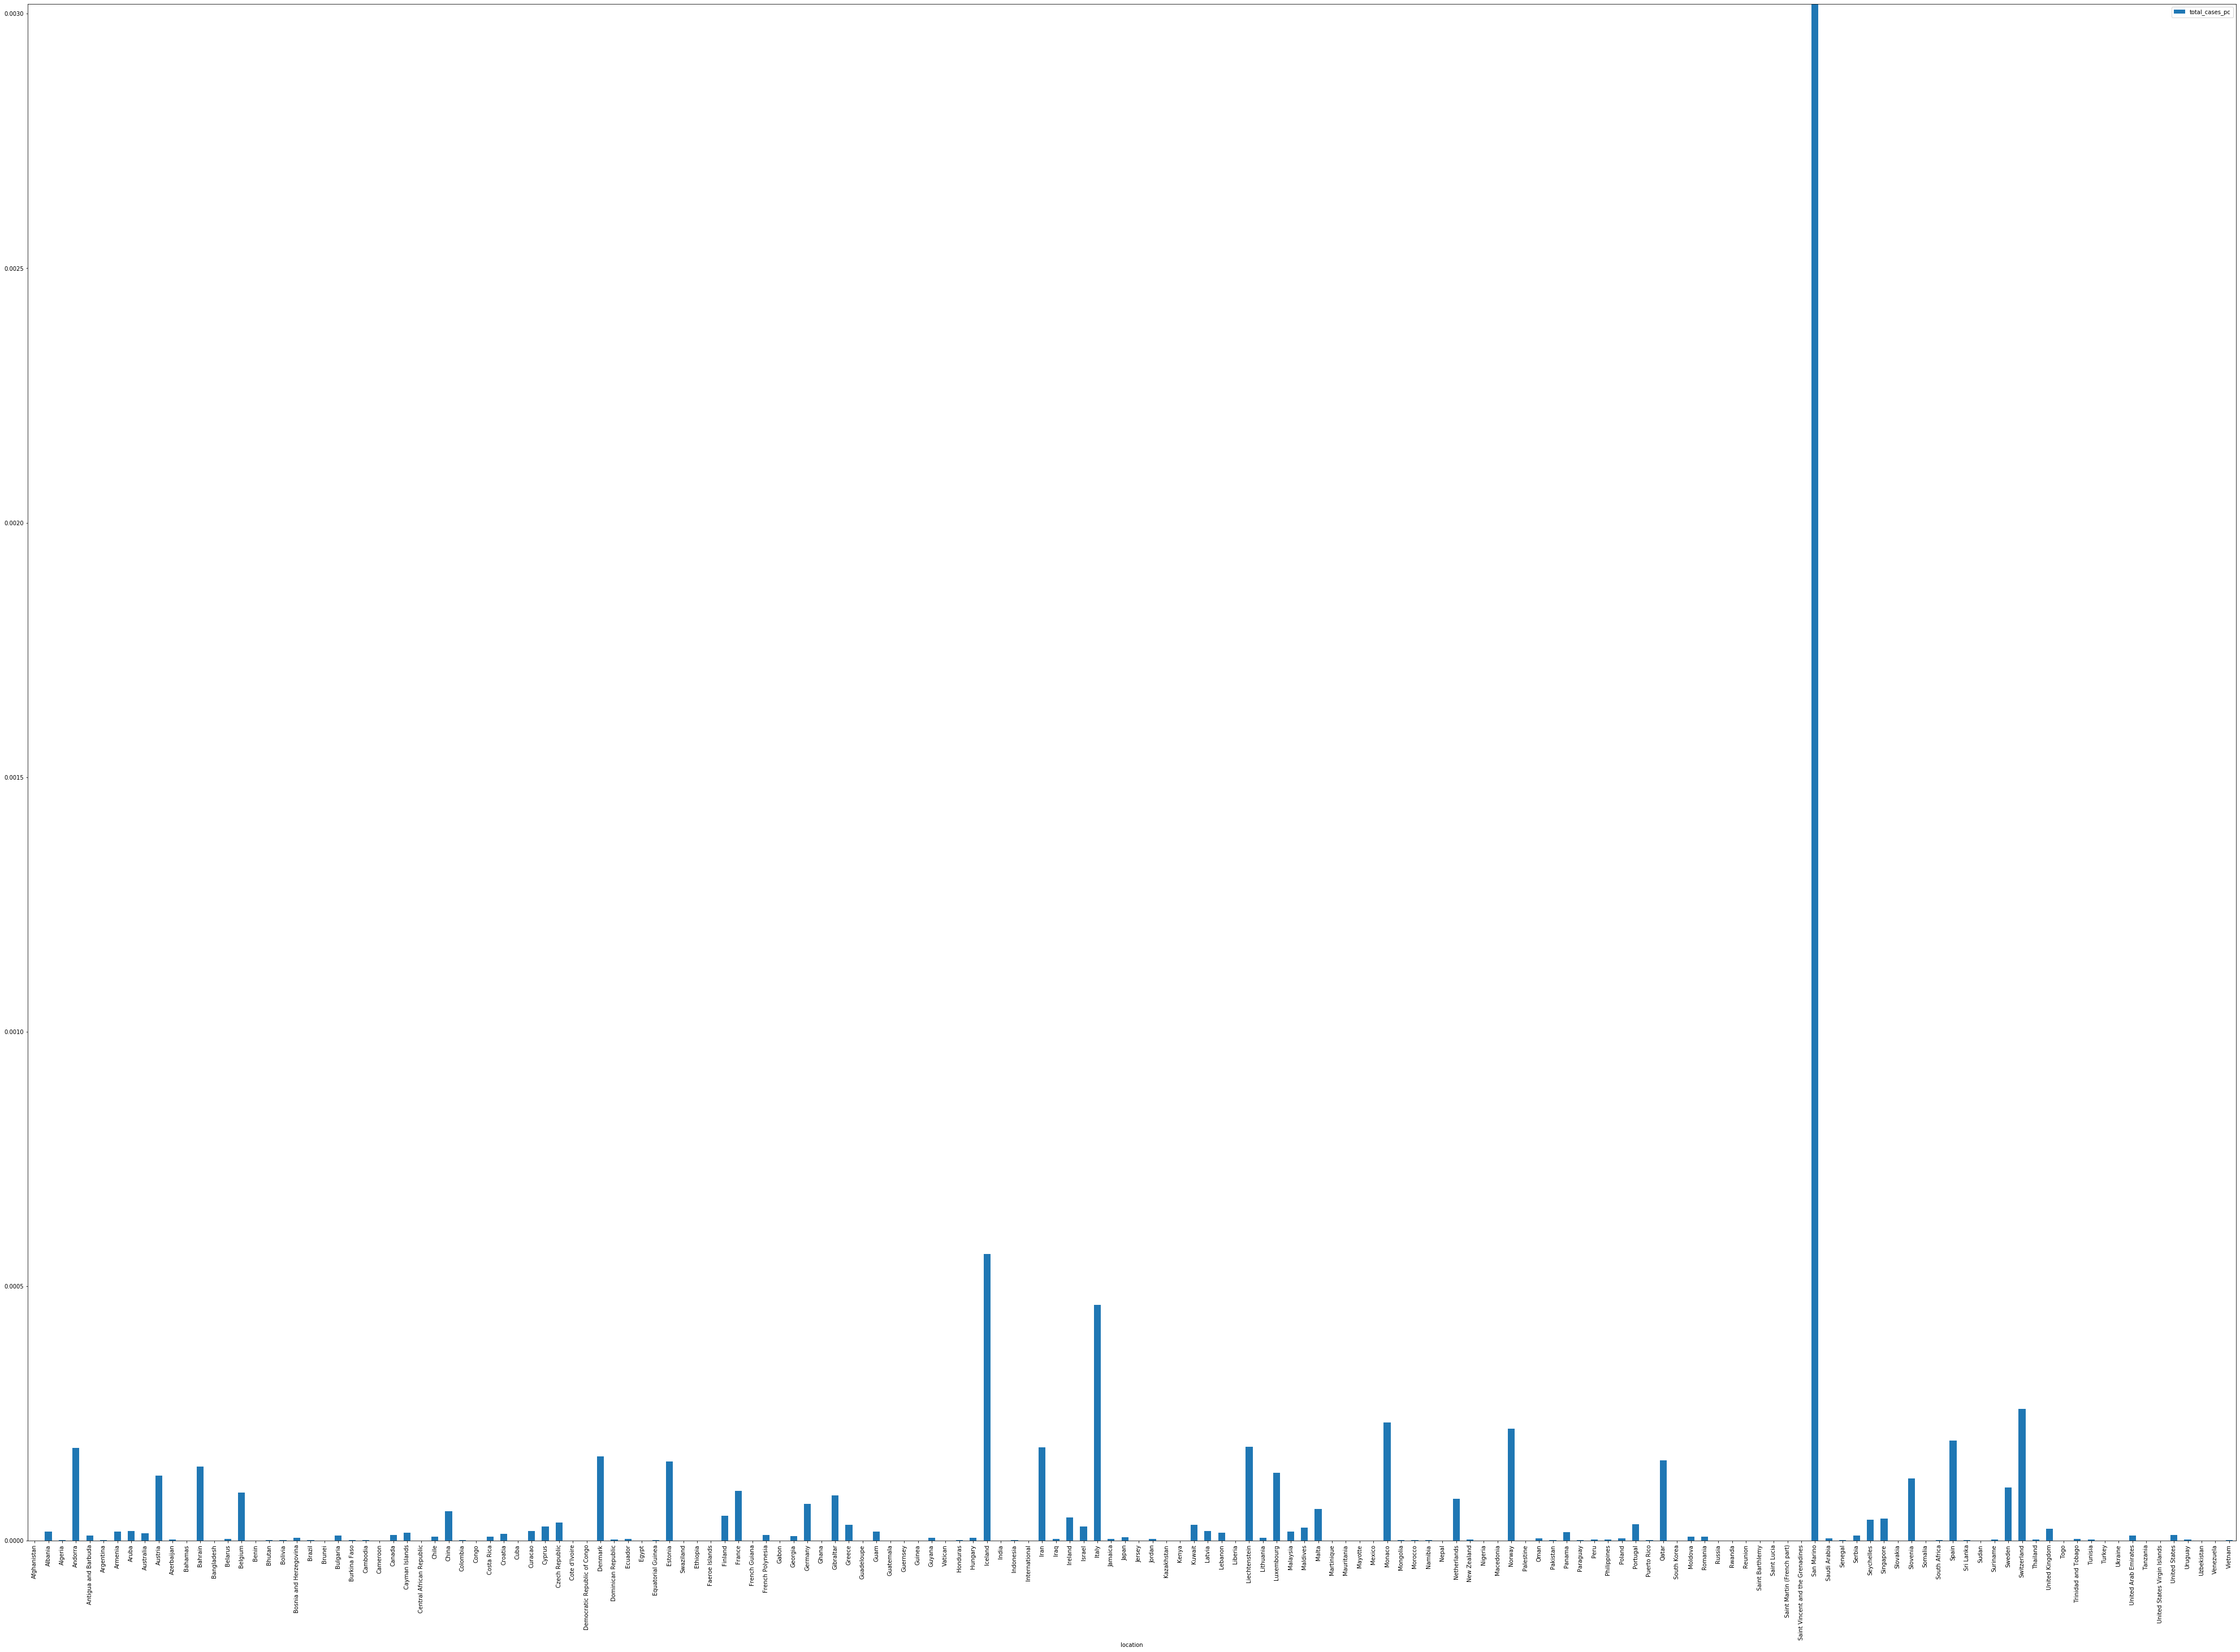

In [51]:
all_rows = data.plot(kind='bar', y = 'total_cases_pc', 
                     figsize = (70, 50), ylim = (0, data['total_cases_pc'].max())).get_figure()
plt.savefig('all_rows.png')

In [52]:
largest5 = data.nlargest(5, 'total_cases_pc')
largest5

,new_cases,new_deaths,total_cases,total_deaths,total_cases_pc,total_deaths_pc,deaths_per_total
location,,,,,,,
San Marino,10,4,102,9,0.003019,0.000266,0.0882
Iceland,61,0,199,0,0.000563,0.000000,0.0000
Italy,3233,694,27980,2503,0.000463,0.000041,0.0895
Switzerland,0,1,2200,14,0.000258,0.000002,0.0064
Monaco,0,0,9,0,0.000233,0.000000,0.0000


In [53]:
largest5['total_cases_pc']

location
San Marino     0.003019
Iceland        0.000563
Italy          0.000463
Switzerland    0.000258
Monaco         0.000233
Name: total_cases_pc, dtype: float64

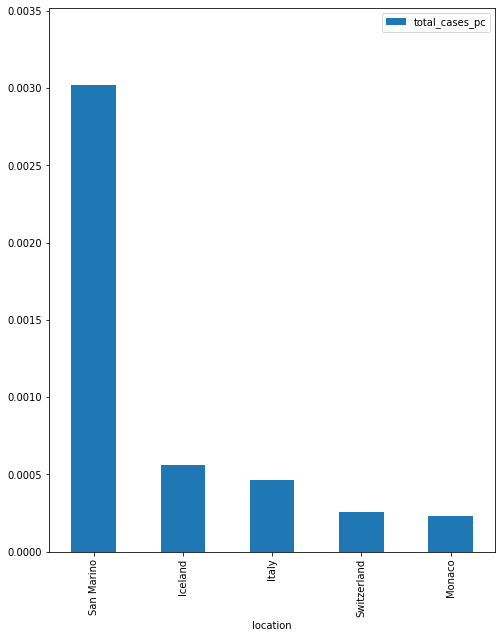

In [54]:
total_cases_pc_fig = largest5.plot(kind='bar', 
                                   y = 'total_cases_pc', 
                                   ylim = (0, data['total_cases_pc'].max()+ 0.0005),
                                   figsize = (8, 10)).get_figure()
plt.savefig('total_cases_pc.png')

In [55]:
print(population[population.index == 'San Marino'])
print(data[data.index == 'San Marino'])

               2018
location           
San Marino  33785.0
            new_cases  new_deaths  total_cases  total_deaths  total_cases_pc  \
location                                                                       
San Marino         10           4          102             9        0.003019   

            total_deaths_pc  deaths_per_total  
location                                       
San Marino         0.000266            0.0882  


In [56]:
deaths_per_cases = data[data['total_cases'] > 50].nlargest(5, 'deaths_per_total')
deaths_per_cases

,new_cases,new_deaths,total_cases,total_deaths,total_cases_pc,total_deaths_pc,deaths_per_total
location,,,,,,,
Italy,3233,694,27980,2503,0.000463,4.141895e-05,0.0895
San Marino,10,4,102,9,0.003019,2.663904e-04,0.0882
Iraq,0,0,124,9,0.000003,2.341701e-07,0.0726
Algeria,11,1,60,4,0.000001,9.472292e-08,0.0667
Philippines,47,0,187,12,0.000002,1.125156e-07,0.0642


In [57]:
deaths_per_cases['deaths_per_total']

location
Italy          0.0895
San Marino     0.0882
Iraq           0.0726
Algeria        0.0667
Philippines    0.0642
Name: deaths_per_total, dtype: float64

In [58]:
deaths_per_cases_pop = deaths_per_cases.merge(population, on = 'location')

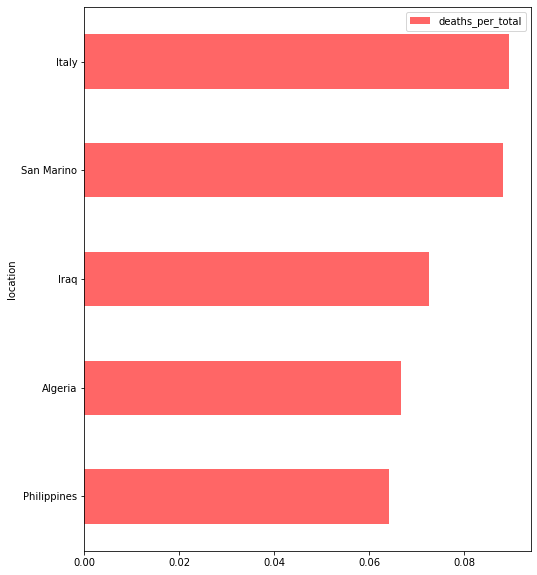

In [59]:
deaths_per_cases_pop.sort_values(by = 'deaths_per_total', ascending = True, inplace = True)
deaths_per_cases_fig = deaths_per_cases_pop.plot.barh(y = 'deaths_per_total', 
                                                      color ='red',
                                                      figsize = (8, 10),
                                                      alpha = 0.6).get_figure()
plt.savefig('deaths_per_cases.png')

In [60]:
filtered_for_table = deaths_per_cases_pop.drop(columns = ['new_cases', 'new_deaths', 'total_cases_pc', 'total_deaths_pc'])
filtered_for_table = filtered_for_table.reset_index()
filtered_for_table = filtered_for_table.rename(columns = {'2018':'population'})
filtered_for_table

,location,total_cases,total_deaths,deaths_per_total,population
0,Philippines,187,12,0.0642,106651922.0
1,Algeria,60,4,0.0667,42228429.0
2,Iraq,124,9,0.0726,38433600.0
3,San Marino,102,9,0.0882,33785.0
4,Italy,27980,2503,0.0895,60431283.0


In [61]:



fig = go.Figure(data=[go.Table(
    header=dict(values=['Location', 
                        'Total Cases', 
                        'Total Deaths',
                        'Deaths per total', 
                        'population'],
                align='left'),
    cells=dict(values=[filtered_for_table['location'], 
                       filtered_for_table['total_cases'], 
                       filtered_for_table['total_deaths'], 
                       filtered_for_table['deaths_per_total'],
                       filtered_for_table['population']
                      ],
               align='left'))
])

fig.show()


## Resources
1. Data obtained from: https://ourworldindata.org/coronavirus-source-data
2. Population data from: https://data.worldbank.org/indicator/SP.POP.TOTL